In [384]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
data = scipy.io.loadmat('data.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Wed May  1 16:31:37 2019',
 '__version__': '1.0',
 '__globals__': [],
 'measurements': array([[-2.01578286e+00, -2.90755100e+00, -2.67744130e+00,
          9.53043089e+00, -2.14360671e-01,  1.06772859e+00,
          2.74434930e+00,  8.60427418e+00, -7.35467346e+00,
         -7.80599949e+00, -1.49797330e+01, -5.93316229e+00,
         -1.17022535e+01, -6.71331334e+00, -3.01375020e+00,
          7.02612740e+00, -6.66765458e-01, -9.18057096e+00,
         -2.61483587e+00, -6.39310722e+00,  6.23473427e+00,
         -1.46211756e+00, -9.56433270e+00,  7.59269033e-01,
         -8.11606610e+00, -1.64683342e+01, -3.78281668e+00,
         -5.97354872e-02,  2.30420684e-02,  1.87384025e+00,
         -1.02493121e+01, -6.44024977e+00, -2.74091998e+00,
         -9.38215695e+00, -2.59333674e+00, -3.92937832e+00,
         -8.47735816e+00, -3.69684610e+00, -1.02905538e+01,
         -8.85671981e+00,  8.29026256e+00, -2.47209602e+00,
      

In [7]:
measurements = data['measurements']
targetState = data['targetState']
measurements.shape


(2, 60)

In [182]:
# State transition matrix
#state vector = [x,y,x_dot,y_dot]
del_t = 1
F_k = np.array([[1,0,del_t,0],[0,1,0,del_t],[0,0,1,0],[0,0,0,1]])
F_k.shape

(4, 4)

In [41]:
q = 0.001 
Q_k = np.array([[(q*del_t**3)/3, q*(del_t**2)/2, 0,0], 
                [q*(del_t**2)/2, q*del_t,0,0],
                [0,0, (q*del_t**3)/3, q*(del_t**2)/2], 
                [0,0,q*(del_t**2)/2,q*del_t]])
Q_k

array([[0.00033333, 0.0005    , 0.        , 0.        ],
       [0.0005    , 0.001     , 0.        , 0.        ],
       [0.        , 0.        , 0.00033333, 0.0005    ],
       [0.        , 0.        , 0.0005    , 0.001     ]])

In [17]:
v_k.shape

(4, 4)

In [240]:
#measurement matrix
H_k = np.array([[1,0,0,0],[0,1,0,0]])
H_k
alpha_x = 5
alpha_y = 5
R_k = np.array([[alpha_x**2,0], [0, alpha_y**2]])
H_k.shape

(2, 4)

In [55]:
estimate = np.zeros((4,60))
gain = np.zeros((1,60))
gain.shape

(1, 60)

In [298]:
def kalmanPrediction(mean, covar, F_k, Q_k):
    priorMean = F_k@mean
    priorCovar = F_k@covar@F_k.T + Q_k
    return priorMean, priorCovar

In [355]:
def kalmanUpdate(priorMean,priorCovar,z,H_k,R_k):
    z_k_estimate = priorMean.T@H_k.T

    S_k = H_k@priorCovar@H_k.T + R_k

    v_k = z - z_k_estimate

    W_k = priorCovar@H_k.T@np.linalg.pinv(S_k)

    mean = (W_k@v_k.T) + priorMean 

#     print(W_k@v_k.T)
    covar = priorCovar - W_k@S_k@W_k.T
    return mean, covar, W_k[0,0]

[[0.         0.         0.         0.8333337  0.70000253 0.60000693
  0.52382352 0.46431006 0.41670536 0.37783553 0.34553682 0.31829482
  0.29502247 0.27492129 0.25739262 0.24197927 0.2283264  0.21615459
  0.20524085 0.19540521 0.1865008  0.17840663 0.17102215 0.16426306
  0.1580582  0.15234707 0.14707784 0.14220588 0.13769252 0.13350403
  0.12961086 0.12598697 0.1226093  0.11945732 0.11651268 0.1137589
  0.1111811  0.10876581 0.10650081 0.10437493 0.10237798 0.1005006
  0.09873421 0.09707091 0.09550345 0.0940251  0.09262971 0.09131158
  0.09006546 0.08888652 0.08777032 0.08671276 0.08571007 0.08475881
  0.0838558  0.08299813 0.08218313 0.08140836 0.08067156 0.0799707 ]]


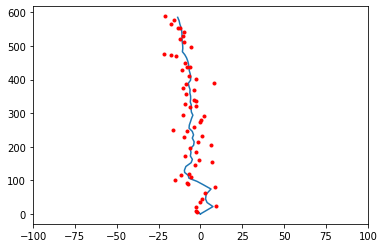

In [400]:
for i in range(60):
    z = np.array([measurements[:,i]])
    if i == 1:

        mean = np.array([[z[0,0], z[0,1], 
                         z[0,0]-measurements[0,i], 
                         z[0,1]-measurements[1,i]]]).T

        covar = np.array([[R_k[0,0], 0, R_k[0,0], 0], 
                          [0, R_k[1,1], 0, R_k[1,1]], 
                          [R_k[0,0], 0, 2*R_k[0,0], 0],
                          [0, R_k[1,1], 0 , 2*R_k[1,1]]])
        
        estimate[:,i] = mean[:,0]
        estimate.shape
    elif i>2:
        priorMean, priorCovar = kalmanPrediction(mean,covar,F_k,Q_k)

#         mean, covar, gain[:,i] = kalmanUpdate(priorMean, priorCovar, z, H_k, R_k)
        mean, covar, gain[:,i] = kalmanUpdate(priorMean, priorCovar, z, H_k, R_k)
#         print(mean.shape)
        estimate[:,i] = mean[:,0]

# Note that even in the OO-style, we use `.pyplot.figure` to create the figure.
fig, ax = plt.subplots()  # Create a figure and an axes.
ax.plot(estimate[0,:], estimate[1,:], label='estimate')
ax.plot(measurements[0,:],  measurements[1,:], 'r.' )
ax.set_xlim(-100,100)
print(gain)
        
#     if i==4:
        
        

In [294]:
priorMean = F_k@mean
priorCovar = F_k@covar@F_k.T + Q_k


z_k_estimate = priorMean.T@H_k.T
#     print(z_k_estimate.shape)
S_k = H_k@priorCovar@H_k.T + R_k
#     print(S_k.shape)
v_k = z - z_k_estimate
#     print(v_k.shape)
W_k = priorCovar@H_k.T@np.linalg.pinv(S_k)
#     print(W_k.shape)
#     print(v_k)
#     print("W_k =",W_k.shape, "prior",priorMean.shape,"v_k",v_k.shape)
mean = (W_k@v_k.T) + priorMean 

#     print(W_k@v_k.T)
covar = priorCovar - W_k@S_k@W_k.T

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 4)

In [377]:
whos

Variable           Type           Data/Info
-------------------------------------------
A                  ndarray        4x1: 4 elems, type `float64`, 32 bytes
B                  ndarray        1x2: 2 elems, type `float64`, 16 bytes
F_k                ndarray        4x4: 16 elems, type `int32`, 64 bytes
H_k                ndarray        2x4: 8 elems, type `int32`, 32 bytes
Q_k                ndarray        4x4: 16 elems, type `float64`, 128 bytes
R_k                ndarray        2x2: 4 elems, type `int32`, 16 bytes
S_k                ndarray        2x2: 4 elems, type `float64`, 32 bytes
V                  ndarray        1x2: 2 elems, type `float64`, 16 bytes
W                  ndarray        4x2: 8 elems, type `float64`, 64 bytes
W_k                ndarray        4x2: 8 elems, type `float64`, 64 bytes
alpha_x            int            5
alpha_y            int            5
ax                 AxesSubplot    AxesSubplot(0.125,0.125;0.775x0.755)
covar              ndarray        4x4: 16 